# Data Preprocessing to Transforming MPP data into images and predicting Transcription Rate (TS)

This notebook is ment to convert raw cell data from several wells into multichannel images (along with its corresponding metadata).

Data was taken from:
`/storage/groups/ml01/datasets/raw/20201020_Pelkmans_NascentRNA_hannah.spitzer/` and server `vicb-submit-01`. 

In the preprocessing done in this notebook, NO discrimination of channels is done! All the channels are saved in the same order and all of them are also projected into a scalars, in case another channel wants to be used as target varaible. The objective of this preprocessing is to create a 'imaged' version of the MPP data.

The discretization of the channels (input_channels) and the selection of the target variable is done during the convertion into tensorflow dataset!

Considerations:
- The MPPData saved in a dictionary and is never merged (only the metadata)! This is because there is not 'in place' option to extend numpy arrays (they need contiguous space in the memory). Therefore, any merging over numpy arrays results into object duplication in memory during the merging process.
- The images are saved as variables in each MPPData instance as arrays of dtype=np.uint16. This saves a lot of ram memory during the processing. However, this only allows values between 0 and 65535 (which is the measure range of MPP data). Therefore, the normalization is done image by image during the saving into disk, again to reduce the use of ram memory.

Load libraries:

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
# To display all the columns
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import math
import matplotlib.pyplot as plt

Load Parameters:

In [3]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/params_imgs_and_scalar_no_split_local.json'

if not os.path.exists(PARAMETERS_FILE):
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))
    
# Open parameters
with open(PARAMETERS_FILE) as params_file:
    p = json.load(params_file)
p.keys()

dict_keys(['_comment', 'raw_data_dir', 'dir_type', 'perturbations_and_wells', 'external_libs_path', 'output_data_dir', 'log_file', 'log_level', 'input_channels', 'output_channels', 'aggregate_output', 'project_into_scalar', 'img_size', 'subtract_background', 'background_value', 'add_cell_cycle_to_metadata', 'cell_cycle_file', 'add_well_info_to_metadata', 'well_info_file', 'filter_criteria', 'filter_values', 'convert_into_image', 'images_dtype', 'remove_original_data'])

Take a look into the loaded parameters:

In [4]:
p

{'_comment': 'Convert mpp data into image----------------------------------',
 'raw_data_dir': '/home/hhughes/Documents/Master_Thesis/Project/datasets/raw',
 'dir_type': 'hannah',
 'perturbations_and_wells': {'184A1_hannah_unperturbed': ['I09', 'I11']},
 'external_libs_path': '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs',
 'output_data_dir': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_no_split',
 'log_file': '/home/hhughes/Documents/Master_Thesis/Project/workspace/logs/Convert_data_into_images.log',
 'log_level': 'INFO',
 'input_channels': ['00_DAPI',
  '07_H2B',
  '01_CDK9_pT186',
  '03_CDK9',
  '05_GTF2B',
  '07_SETD1A',
  '08_H3K4me3',
  '09_SRRM2',
  '10_H3K27ac',
  '11_KPNA2_MAX',
  '12_RB1_pS807_S811',
  '13_PABPN1',
  '14_PCNA',
  '15_SON',
  '16_H3',
  '17_HDAC3',
  '19_KPNA1_MAX',
  '20_SP100',
  '21_NCL',
  '01_PABPC1',
  '02_CDK7',
  '03_RPS6',
  '05_Sm',
  '07_POLR2A',
  '09_CCNT1',
  '10_POL2RA_pS2',
  '11_PML',
  '12_YAP1',
 

Set paths and Load external libraries:

In [5]:
# Load data path
DATA_DIR = p['raw_data_dir']
if not os.path.exists(DATA_DIR):
    raise Exception('Data path {} does not exist!'.format(DATA_DIR))
else:
    print('DATA_DIR: {}'.format(DATA_DIR))

# Load external libraries path
EXTERNAL_LIBS_PATH = p['external_libs_path']
if not os.path.exists(EXTERNAL_LIBS_PATH):
    raise Exception('External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH))
else:
    print('EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH))
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)
# Load external libraries
from pelkmans.mpp_data import MPPData as MPPData
from pelkmans.mpp_data import save_to_file_targets_masks_and_normalized_images as normalize_and_save
from pelkmans.mpp_data import get_image_normalization_vals as get_normalization_vals
from pelkmans.mpp_data import get_concatenated_metadata as get_concatenated_metadata

# Set logging configuration
import logging
logging.basicConfig(
    filename=p['log_file'],
    filemode='w', 
    level=getattr(logging, p['log_level'])
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))

DATA_DIR: /home/hhughes/Documents/Master_Thesis/Project/datasets/raw
EXTERNAL_LIBS_PATH: /home/hhughes/Documents/Master_Thesis/Project/workspace/libs


Check available data (Perturbations and Wells):

In [6]:
logging.info('Reading local available perturbations-wells...')
# Save available local Perturbations and Wells
perturbations = [per for per in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, per))]
local_data = {}
#print('Local available perturbations-wells:\n')
for per in perturbations:
    pertur_dir = os.path.join(DATA_DIR, per)
    wells = [w for w in os.listdir(pertur_dir) if os.path.isdir(os.path.join(pertur_dir, w))]
    #print('{}\n\t{}\n'.format(p, wells))
    local_data[per] = wells

Select Perturbations and its wells to process: 

In [7]:
msg = 'Local available perturbations-wells:\n{}'.format(local_data)
print(msg)
logging.debug(msg)

# In case you only want to load some specific perturbations and/or wells here:
#selected_data = {
#    '184A1_hannah_unperturbed': ['I11', 'I09'],
#    '184A1_hannah_TSA': ['J20', 'I16'],
#}

# Load perturbations-wells from parameters file
selected_data = p['perturbations_and_wells']
# How many wlls will be processed?
n_wells = 0
for key in list(selected_data.keys()):
    n_wells += len(selected_data[key])

print('\nSelected perturbations-wells:\n{}'.format(selected_data))

#Generate and save data dirs
data_dirs = []
for per in selected_data.keys():
    for w in selected_data[per]:
        d = os.path.join(DATA_DIR, per, w)
        data_dirs.append(d)
        if not os.path.exists(d):
            msg = '{} does not exist!\nCheck if selected_data contain elements only from local_data dict.'.format(d)
            logging.error(msg)
            raise Exception(msg)
p['data_dirs'] = data_dirs

Local available perturbations-wells:
{'184A1_hannah_unperturbed': ['I11', 'I09', 'J10'], '184A1_hannah_AZD4573': ['J14', 'I13', 'J18', 'J21', 'I17'], '184A1_hannah_TSA': ['J20', 'I16', 'J13']}

Selected perturbations-wells:
{'184A1_hannah_unperturbed': ['I09', 'I11']}


Process data:

In [8]:
msg = 'Starting processing of {} wells...'.format(n_wells)
logging.info(msg)

data = []

for w, data_dir in enumerate(p['data_dirs'], 1):
    msg = 'Processing well {}/{} from dir {}...'.format(w, n_wells, data_dir)
    logging.info(msg)
    print('\n\n'+msg)
    # Load data as an MPPData object
    mpp_temp = MPPData.from_data_dir(data_dir,
                                     dir_type=p['dir_type'])
    
    # Add cell cycle to metadata (G1, S, G2)
    # Important! If mapobject_id_cell is not in cell_cycle_file =>
    # its corresponding cell is in Mitosis phase!
    if p['add_cell_cycle_to_metadata']:
        msg = 'Adding cell cycle to metadata...'
        logging.info(msg)
        print(msg)
        mpp_temp.add_cell_cycle_to_metadata(os.path.join(DATA_DIR, p['cell_cycle_file']))
    
    # Add well info to metadata
    if p['add_well_info_to_metadata']:
        msg = 'Adding well info to metadata...'
        logging.info('Adding well info to metadata...')
        print(msg)
        mpp_temp.add_well_info_to_metadata(os.path.join(DATA_DIR, p['well_info_file']))
    
    # Remove unwanted cells
    if p.get('filter_criteria', None) is not None:
        msg = 'Removing unwanted cells...'
        logging.info(msg)
        print(msg)
        mpp_temp.filter_cells(p['filter_criteria'], p['filter_values'])

    # Subtract background  values for each channel
    if p['subtract_background']:
        print('Subtracting background...')
        mpp_temp.subtract_background(os.path.join(DATA_DIR, p['background_value']))
    
    # Project every uni-channel images into a scalar for further analysis
    if p['project_into_scalar']:
        msg = 'Projecting data...'
        logging.info(msg)
        print(msg)
        mpp_temp.add_scalar_projection(p['aggregate_output'])
        
    
    if p['convert_into_image']:
        msg = 'Converting data into images...'
        logging.info(msg)
        print(msg)
        mpp_temp.add_image_and_mask(data='MPP', remove_original_data=p['remove_original_data'], img_size=p['img_size'])
        msg = 'Data converted'
        logging.info(msg)
        print(msg)
    
    # Validate same channels across wells
    if len(data) > 0:
        if not all(data[0].channels.name == mpp_temp.channels.name):
            raise Exception('Channels across MPPData instances are not the same!')
            
    data.append(mpp_temp)
    del(mpp_temp)
    



Processing well 1/2 from dir /home/hhughes/Documents/Master_Thesis/Project/datasets/raw/184A1_hannah_unperturbed/I09...
Adding cell cycle to metadata...
Adding well info to metadata...
Removing unwanted cells...
Total number of cells: 886
269 cells cutted by filter: is_border_cell == 1
30 cells cutted by filter: is_polynuclei_184A1 == 1
41 cells cutted by filter: is_polynuclei_HeLa == 1
323 cells cutted by filter: cell_cycle == NaN
Number of cutted cells: 324
Subtracting background...
Projecting data...
Converting data into images...
Deleting origin MPPData...
Data converted


Processing well 2/2 from dir /home/hhughes/Documents/Master_Thesis/Project/datasets/raw/184A1_hannah_unperturbed/I11...
Adding cell cycle to metadata...
Adding well info to metadata...
Removing unwanted cells...
Total number of cells: 1025
333 cells cutted by filter: is_border_cell == 1
33 cells cutted by filter: is_polynuclei_184A1 == 1
33 cells cutted by filter: is_polynuclei_HeLa == 1
375 cells cutted by fil

In [9]:
# During this pre-processing we save all channels!
channels_ids = data[0].channels.channel_id.values

As an extra, all channels are projected into an scalar and saved in the metadata. The idea of this is to have scalar data to make simpler analysis. This projected data is also normalized using the train projection values.

In [17]:
# Merge metadata
msg = 'Merging metadata...'
logging.info(msg)

metadata, _ = get_concatenated_metadata(
    mppdata_dict={'data':data},
    normalize=0,
    projection_method=p['aggregate_output'])
metadata

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg
0,373506,373535,plate01,I09,0,0,0,0,6,0,plate01,I09,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12969.0,43.893030,175.995428,27.577226,54.206169,128.697294,41.469521,60.416069,64.842372,125.169772,65.557846,105.751293,192.479292,78.460671,49.046642,187.326717,99.378451,117.227410,26.282266,60.407161,33.006360,131.946547,28.173045,54.011811,187.774103,131.526724,385.672558,11.862217,81.837107,291.005551,51.128612,368.260323,285.676524,11.584543,8.256946,1.803026,599.449225,8305.377207,10121.675842
1,373507,373536,plate01,I09,0,0,0,0,7,0,plate01,I09,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,9846.0,39.837376,273.655677,12.569294,22.001503,81.730022,20.032913,39.631146,44.481310,73.860256,54.789958,67.896671,162.914590,35.864765,37.245010,355.807515,67.943580,76.462250,12.614654,55.775873,14.612852,120.283067,19.574581,41.063924,101.116543,55.055405,297.648758,11.671538,91.374197,329.135675,33.598199,335.386680,410.320858,9.813957,5.888977,1.561608,398.334857,6055.847451,10278.970546
2,373508,373537,plate01,I09,0,0,0,0,8,0,plate01,I09,0,0,0,0,8,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,7714.0,44.735922,258.942987,23.616477,47.406444,140.684383,44.831516,68.078372,67.289663,85.795525,90.090190,87.339633,249.505730,88.193348,51.833120,332.372822,124.072929,130.945283,38.285344,76.223063,43.566143,151.189717,39.663339,71.273700,205.703836,124.654347,332.255405,17.381051,196.612601,361.317387,55.593623,457.713302,469.516855,14.441616,9.757942,1.859657,464.431683,8280.577392,11757.616541
3,373509,373538,plate01,I09,0,0,0,0,9,0,plate01,I09,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,15718.0,43.931378,194.444293,18.353704,32.399117,104.564078,29.361877,46.617407,51.506499,127.183208,55.535536,94.269486,171.038290,77.086018,32.756867,212.862917,74.396402,81.701189,15.256486,49.931726,19.315464,136.797350,21.712636,45.183902,148.422635,82.323469,284.648928,8.077076,50.190543,271.552491,37.614959,285.612350,263.922204,7.988940,6.477020,1.717521,425.533338,7441.930589,8530.446240
4,373510,373539,plate01,I09,0,0,0,0,10,0,plate01,I09,0,0,0,0,10,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12229.0,30.892690,231.842236,19.046228,37.117579,100.918987,25.272207,43.387094,43.176593,78.249253,76.013457,112.938592,178.444723,81.792631,41.639270,292.071767,90.931247,99.625565,27.330404,66.549839,20.411372,107.398853,23.828493,55.354041,134.139140,99.027838,301.044591,15.211128,122.575573,334.431894,42.139486,362.906348,438.364101,10.736532,6.967087,1.697280,410.540764,5541.760160,10350.776433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,345256,345314,plate01,I11,5,4,0,0,46,0,plate01,I11,5,4,0,0,46,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,10905.0,36.062769,179.172169,14.333868,29.928694,87.526719,24.361459,41.703268,42.342392,63.066734,34.786499,93.865902,191.669215,48.745502,40.7

## Save data

Prepare to save data:

In [18]:
import shutil

msg = 'Starting data saving process...'
logging.info(msg)

# create dir
outdir = p['output_data_dir']
if os.path.exists(outdir):
    msg = 'Warning! Directory {} already exist! Deleting...\n'.format(outdir)
    logging.info(msg)
    print(msg)
    try:
        shutil.rmtree(outdir)
    except OSError as e:
        msg  = 'Dir {} could not be deleted!\n\nOSError: {}'.format(outdir, e)
        logging.info(msg)
        print(msg)

msg = 'Creating dir: {}'.format(outdir)
logging.info(msg)
print(msg)
os.makedirs(outdir, exist_ok=False)
    

Creating dir: /home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_no_split


Save Images, masks and targets of all channels into separated files using the mapobject_id_cell of each cell:

In [19]:
if p['convert_into_image']: 
    msg = 'Saving images and masks...'
    logging.info(msg)
    
    output_files = normalize_and_save(
        mppdata_dict={'data':data},
        channels_ids=channels_ids,
        projection_method=p['aggregate_output'],
        outdir=outdir,
        dtype=getattr(np, p['images_dtype'])
    )
    p['output_files'] = output_files
    print(output_files)

Saving data images and masks...
Saving 562 images form data-well 0/2...
Saving 648 images form data-well 1/2...
MPPData images and masks saving process finished!
{'data': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_no_split/data'}


Save metadata and used parameters

In [58]:
msg = 'Saving Parameters and Metadata...'
logging.info(msg)

# save params
with open(os.path.join(outdir, 'params.json'), 'w') as file:
    json.dump(p, file, indent=4)

# save metadata
with open(os.path.join(outdir, 'metadata.csv'), 'w') as file:
    metadata.to_csv(file, index=False)

# Save used channels
with open(os.path.join(outdir, 'channels.csv'), 'w') as file:
    #train.channels
    data[0].channels.to_csv(file, index=False)

Finally, load one saved file and take a look into the content to see if everithing was done correctlly:

Cell image shape: (224, 224, 38)

Cell mask shape: (224, 224)

Cell target shape: (38,)



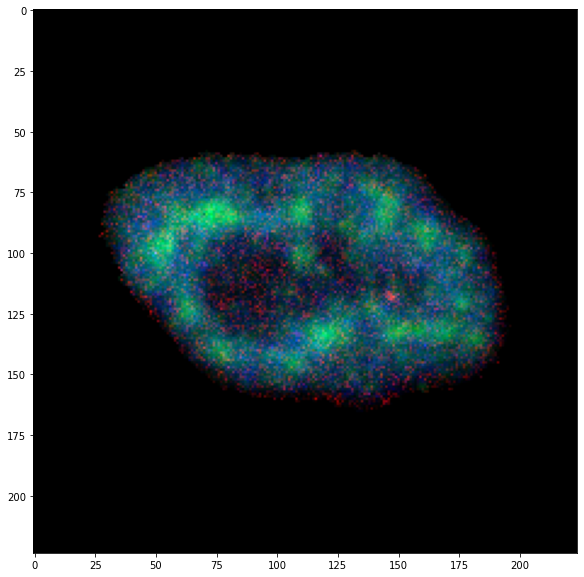


Cell targets: [2.87836266e+01 1.70480072e+02 8.56645298e+00 1.27111387e+01
 7.40450745e+01 1.45677624e+01 3.30579453e+01 2.30709610e+01
 3.42033577e+01 3.79004669e+01 2.04725909e+00 1.45023483e+02
 3.58084183e+01 2.76596622e+01 1.79408173e+02 5.95606384e+01
 5.64891663e+01 1.87583981e+01 3.77584686e+01 1.89089718e+01
 9.47422562e+01 1.57345495e+01 3.90367889e+01 7.41046982e+01
 4.08653488e+01 2.42195877e+02 1.04033012e+01 8.93114014e+01
 2.01871460e+02 3.34733887e+01 2.98405762e+02 2.61056427e+02
 8.02370262e+00 4.88606930e+00 1.65530026e+00 3.74989960e+02
 4.66537158e+03 8.36261328e+03]



In [57]:
cell_id = np.random.choice(metadata['mapobject_id_cell'].values)
file = os.path.join(outdir, 'data', str(cell_id)+'.npz')
cell = np.load(file)
cell_img = cell['img']
cell_img = cell_img / np.max(cell_img, axis=(0,1))
cell_mask = cell['mask']
cell_targets = cell['targets']

print('Cell image shape: {}\n'.format(cell_img.shape))
print('Cell mask shape: {}\n'.format(cell_mask.shape))
print('Cell target shape: {}\n'.format(cell_targets.shape))

# Now take a look into its image
plt.figure(figsize=(10,10))
plt.imshow(cell_img[:,:,10:13],
           cmap=plt.cm.PiYG,
           vmin=0, vmax=5000,
           #norm=True,
           aspect='equal'
          )
plt.show()

print('\nCell targets: {}\n'.format(cell_targets))

logging.info('\n\nPREPROCESSING FINISHED!!!!----------------------')

In [64]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_i2', 'np', 'pd', 'os', 'sys', 'plt', 'json', 'math', '_i3', 'PARAMETERS_FILE', 'params_file', 'p', '_3', '_i4', '_4', '_i5', 'DATA_DIR', 'EXTERNAL_LIBS_PATH', 'MPPData', 'normalize_and_save', 'get_normalization_vals', 'get_concatenated_metadata', 'logging', '_i6', 'perturbations', 'local_data', 'per', 'pertur_dir', 'wells', '_i7', 'msg', 'selected_data', 'n_wells', 'key', 'data_dirs', 'w', 'd', '_i8', 'data', 'data_dir', '_i9', 'channels_ids', '_i10', '_10', '_i11', '_11', '_i12', '_12', '_i13', '_13', '_i14', 'metadata', '_i15', '_i16', '_16', '_i17', '_17', '_i18', 'shutil', 'outdir', '_i19', 'output_files', '_i20', 'file', '_i21', '_i22', 'cell_id', '_i23', 'cell', 'cell_img', 'cell_mask', 'cell_targets', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i30', '_30', 

In [66]:
path_temp = os.path.realpath(__name__)
os.path.dirname(path_temp)

'/home/hhughes/Documents/Master_Thesis/Project/workspace/notebooks'